#  Hybrid Quantum-Classical Architectures with PennyLane and PyTorch

This notebook reproduces the hybrid quantum-classical using PennyLane + PyTorch

We will:

1. Build a **binary classifier** using a hybrid neural network
   (classical PyTorch layers + quantum layer).
2. Perform **hyperparameter tuning** of the learning rate with Optuna.
3. Extend the idea to a **multi-class classifier**.


## Installing dependencies (optional)

If you're running this notebook on a managed environment (like a custom Docker
image or a course environment) you may already have everything installed and can
skip this cell.

If you are on Google Colab or a fresh environment, run the cell below.


In [ ]:
!pip install pennylane torch scikit-learn optuna matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 57.0 MB/s eta 0:00:00


## Imports, random seeds, and a helper for plotting losses

In this section we:

- Import NumPy, PyTorch, PennyLane and scikit-learn.
- Fix random seeds for reproducibility.
- Define a small helper function to plot training and validation loss curves.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pennylane as qml

# Reproducibility
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

# Use double precision (similar to tf.float64 in the original notebook)
torch.set_default_dtype(torch.float64)

def plot_losses(train_losses, val_losses):
    """Plot training and validation loss curves."""
    epochs = np.arange(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label="Training loss")
    plt.plot(epochs, val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


## Quantum observable: projector onto |0⟩

We reuse the same observable as in the original notebook: the projector onto
the computational basis state |0⟩.

This gives us a measurement operator we can use inside our quantum circuit.


In [ ]:
# Projector onto |0>
state_0 = np.array([[1.0], [0.0]])
M = state_0 @ state_0.conj().T  # 2x2 Hermitian matrix


## Binary classification dataset

We generate a synthetic binary classification problem with 20 features using
`make_classification`. Then we split into train/validation/test sets and convert
everything to PyTorch tensors.


In [ ]:
# Generate a binary classification dataset
x, y = make_classification(
    n_samples=1000,
    n_features=20,
    random_state=seed
)

# Train / test split
x_tr, x_test, y_tr, y_test = train_test_split(
    x, y, train_size=0.8, random_state=seed
)

# Validation / test split
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size=0.5, random_state=seed
)

# Convert to PyTorch tensors
x_tr_torch = torch.tensor(x_tr, dtype=torch.get_default_dtype())
x_val_torch = torch.tensor(x_val, dtype=torch.get_default_dtype())
x_test_torch = torch.tensor(x_test, dtype=torch.get_default_dtype())

# Rebuild binary labels as 1D float tensors
y_tr_torch = torch.tensor(y_tr, dtype=torch.get_default_dtype())
y_val_torch = torch.tensor(y_val, dtype=torch.get_default_dtype())
y_test_torch = torch.tensor(y_test, dtype=torch.get_default_dtype())

# Dataloaders for the binary problem
batch_size = 10
train_loader_bin = DataLoader(
    TensorDataset(x_tr_torch, y_tr_torch),
    batch_size=batch_size,
    shuffle=True
)
val_loader_bin = DataLoader(
    TensorDataset(x_val_torch, y_val_torch),
    batch_size=batch_size,
    shuffle=False
)
test_loader_bin = DataLoader(
    TensorDataset(x_test_torch, y_test_torch),
    batch_size=batch_size,
    shuffle=False
)




## Quantum circuit and PennyLane TorchLayer (binary classification)

We now:

- Define a small **TwoLocal** variational ansatz (as in the original notebook).
- Create a **PennyLane device** with 4 qubits.
- Define a `qnode` that:
  - Angle-embeds a 4-dimensional classical input.
  - Applies the TwoLocal ansatz.
  - Measures the expectation value of the projector onto |0⟩ on one qubit.
- Wrap the QNode into a **`qml.qnn.TorchLayer`** so it becomes a standard
  PyTorch layer.


In [ ]:
n_qubits = 4
dev = qml.device("lightning.qubit", wires=n_qubits)

def TwoLocal(nqubits, theta, reps=1):
    """Simple TwoLocal ansatz with RY rotations and CNOT entanglers."""
    for r in range(reps):
        # Single-qubit rotations
        for i in range(nqubits):
            qml.RY(theta[r * nqubits + i], wires=i)
        # Entangling layer
        for i in range(nqubits - 1):
            qml.CNOT(wires=[i, i + 1])
    # Final layer of RY rotations
    for i in range(nqubits):
        qml.RY(theta[reps * nqubits + i], wires=i)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def qnn_binary(inputs, theta):
    """Quantum node for the binary classifier."""
    # inputs has dimension 4 (output of a classical layer)
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    TwoLocal(n_qubits, theta, reps=2)
    # Single expectation value
    return qml.expval(qml.Hermitian(M, wires=[0]))

# 2 reps * 4 qubits + final layer of 4 = 12 parameters total
weight_shapes_binary = {"theta": 12}

# Convert qnode into a PyTorch layer
qlayer_binary = qml.qnn.TorchLayer(qnn_binary, weight_shapes_binary)


## Hybrid quantum–classical binary classifier (PyTorch)

We now build a PyTorch `nn.Module` that mirrors the original TF/Keras model:

1. A classical dense layer: 20 → 4 with a sigmoid activation.
2. The quantum layer (PennyLane `TorchLayer`), which expects a 4D input and
   returns a single expectation value.
3. A final sigmoid activation to interpret the expectation value as a probability.

We'll then use **binary cross-entropy** (`BCELoss`) as the loss function.


In [ ]:
class HybridBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Same as the Keras model: 20 -> 4 with sigmoid
        self.fc1 = nn.Linear(20, 4)
        self.act1 = nn.Sigmoid()

        # Quantum layer: expectation of projector onto |0>
        # qlayer_binary must already be defined from earlier
        self.qlayer = qlayer_binary

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.qlayer(x)      # expectation values in [0, 1]
        return x.squeeze(-1)    # ensure shape [batch]

model_binary = HybridBinaryClassifier()

# Use BCELoss on probabilities in [0, 1]
criterion_binary = nn.BCELoss()
optimizer_binary = optim.Adam(model_binary.parameters(), lr=0.005)


## Training utilities and early stopping

PyTorch does not have the high-level `.fit()` API of Keras, so we implement:

- `evaluate_binary(...)` to compute loss and accuracy on a given dataloader.
- `train_model_binary(...)` which:
  - Runs the training loop.
  - Tracks validation loss.
  - Uses a simple **early stopping** mechanism based on validation loss.

This mirrors the original Keras+EarlyStopping behavior.


In [ ]:
def evaluate_binary(model, data_loader, criterion):
    """Compute average loss and accuracy over a dataloader (binary case)."""
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for xb, yb in data_loader:
            probs = model(xb)                # probabilities in [0, 1], shape [batch]
            loss = criterion(probs, yb)      # yb is [batch]
            total_loss += loss.item() * xb.size(0)

            preds = (probs >= 0.5).cpu().numpy().astype(int)
            targets = yb.cpu().numpy().astype(int)
            all_preds.append(preds)
            all_targets.append(targets)

    avg_loss = total_loss / len(data_loader.dataset)
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)
    acc = accuracy_score(all_targets, all_preds)
    return avg_loss, acc


def train_model_binary(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    n_epochs=50,
    patience=3
):
    """Train the binary classifier with early stopping."""
    best_val_loss = float("inf")
    best_state = None

    train_losses = []
    val_losses = []
    epochs_no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_train_loss = 0.0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            probs = model(xb)               # probabilities in [0, 1]
            loss = criterion(probs, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        val_loss, val_acc = evaluate_binary(model, val_loader, criterion)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch:03d} | "
            f"train loss = {avg_train_loss:.4f} | "
            f"val loss = {val_loss:.4f} | "
            f"val acc = {val_acc:.4f}"
        )

        # Early stopping
        if val_loss + 1e-6 < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return train_losses, val_losses


## Training and evaluation (binary classifier)

We now train the hybrid binary classifier, plot the training and validation
loss curves, and report accuracy on the train/validation/test sets.


Epoch 001 | train loss = 0.6869 | val loss = 0.6748 | val acc = 0.5300
Epoch 002 | train loss = 0.6518 | val loss = 0.6239 | val acc = 0.9400
Epoch 003 | train loss = 0.6097 | val loss = 0.5796 | val acc = 0.9500
Epoch 004 | train loss = 0.5713 | val loss = 0.5532 | val acc = 0.9000
Epoch 005 | train loss = 0.5453 | val loss = 0.5321 | val acc = 0.9500
Epoch 006 | train loss = 0.5309 | val loss = 0.5276 | val acc = 0.9000
Epoch 007 | train loss = 0.5231 | val loss = 0.5186 | val acc = 0.9300
Epoch 008 | train loss = 0.5159 | val loss = 0.5088 | val acc = 0.9300
Epoch 009 | train loss = 0.5036 | val loss = 0.4876 | val acc = 0.9400
Epoch 010 | train loss = 0.4779 | val loss = 0.4492 | val acc = 0.9600
Epoch 011 | train loss = 0.4441 | val loss = 0.4154 | val acc = 0.9800
Epoch 012 | train loss = 0.4191 | val loss = 0.3906 | val acc = 0.9800
Epoch 013 | train loss = 0.4017 | val loss = 0.3764 | val acc = 0.9800
Epoch 014 | train loss = 0.3897 | val loss = 0.3626 | val acc = 0.9900
Epoch 

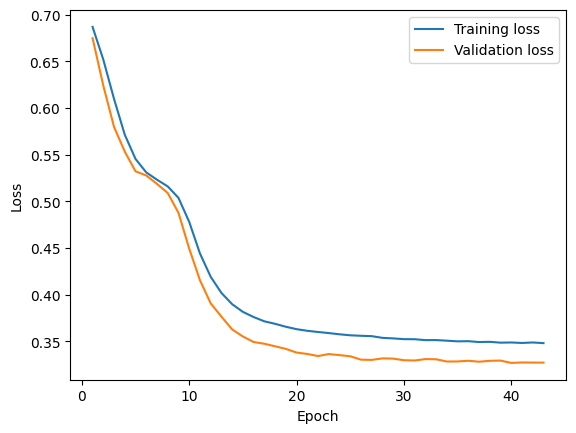

Binary classifier results
-------------------------
Train accuracy:      0.9475
Validation accuracy: 1.0
Test accuracy:       0.88


In [ ]:
# Train
train_losses_bin, val_losses_bin = train_model_binary(
    model_binary,
    train_loader_bin,
    val_loader_bin,
    criterion_binary,
    optimizer_binary,
    n_epochs=50,
    patience=3
)

# Plot losses
plot_losses(train_losses_bin, val_losses_bin)

# Final accuracies
tr_loss, tr_acc = evaluate_binary(model_binary, train_loader_bin, criterion_binary)
val_loss, val_acc = evaluate_binary(model_binary, val_loader_bin, criterion_binary)
test_loss, test_acc = evaluate_binary(model_binary, test_loader_bin, criterion_binary)

print("Binary classifier results")
print("-------------------------")
print("Train accuracy:     ", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:      ", test_acc)


## Confusion matrix for the binary classifier

We now plot the confusion matrix on the test set to see how the hybrid
model performs in terms of true positives, true negatives, false positives and
false negatives.


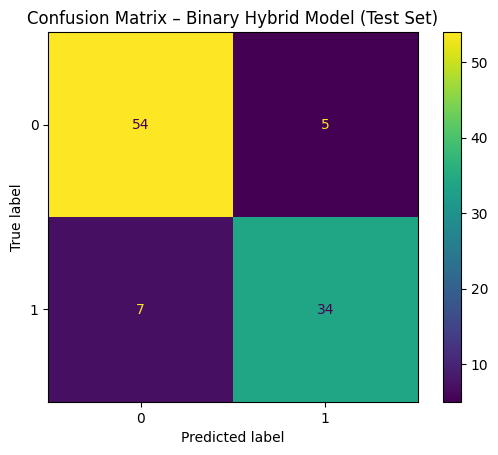

Confusion matrix:
[[54  5]
 [ 7 34]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_preds_and_targets(model, data_loader):
    """Collect all predictions and true labels from a dataloader (binary)."""
    model.eval()
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for xb, yb in data_loader:
            probs = model(xb)                           # probabilities in [0, 1]
            preds = (probs >= 0.5).cpu().numpy().astype(int)

            targets = yb.cpu().numpy().astype(int)
            all_preds.append(preds)
            all_targets.append(targets)

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)
    return y_true, y_pred

# Get predictions and targets on the test set
y_true_test, y_pred_test = get_preds_and_targets(model_binary, test_loader_bin)

# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix – Binary Hybrid Model (Test Set)")
plt.show()

print("Confusion matrix:")
print(cm)


In [ ]:
print(cm)

[[ 0 59]
 [ 0 41]]


## 11. Multi-class dataset (3 classes, PyTorch-friendly)

We now create a 3-class classification dataset with 20 features.

Unlike the binary case, we keep labels as **integer class indices** (0, 1, 2)
and use `CrossEntropyLoss`, which expects:

- logits of shape `(batch_size, n_classes)` from the model
- integer labels of shape `(batch_size,)`


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# New multi-class dataset: 3 classes, 20 features
x_multi, y_multi = make_classification(
    n_samples=1000,
    n_features=20,
    n_classes=3,
    n_clusters_per_class=1,
    random_state=seed
)

# Train / test split
x_tr_m, x_test_m, y_tr_m, y_test_m = train_test_split(
    x_multi, y_multi, train_size=0.8, random_state=seed
)

# Validation / test split
x_val_m, x_test_m, y_val_m, y_test_m = train_test_split(
    x_test_m, y_test_m, train_size=0.5, random_state=seed
)

# Convert to PyTorch tensors
x_tr_m_torch = torch.tensor(x_tr_m, dtype=torch.get_default_dtype())
x_val_m_torch = torch.tensor(x_val_m, dtype=torch.get_default_dtype())
x_test_m_torch = torch.tensor(x_test_m, dtype=torch.get_default_dtype())

# CrossEntropyLoss expects labels as int64 with shape [batch]
y_tr_m_torch = torch.tensor(y_tr_m, dtype=torch.long)
y_val_m_torch = torch.tensor(y_val_m, dtype=torch.long)
y_test_m_torch = torch.tensor(y_test_m, dtype=torch.long)

from torch.utils.data import TensorDataset, DataLoader

train_loader_multi = DataLoader(
    TensorDataset(x_tr_m_torch, y_tr_m_torch),
    batch_size=10,
    shuffle=True
)
val_loader_multi = DataLoader(
    TensorDataset(x_val_m_torch, y_val_m_torch),
    batch_size=10,
    shuffle=False
)
test_loader_multi = DataLoader(
    TensorDataset(x_test_m_torch, y_test_m_torch),
    batch_size=10,
    shuffle=False
)


## 12. Quantum circuit and TorchLayer for 3-class outputs

We reuse the same 4-qubit device and `TwoLocal` ansatz as before, but now:

- The QNode returns **three expectation values**, one per class.
- Each is the expectation value of the projector onto |0⟩ on a different wire.

These three expectation values form a 3D output vector, which we treat as
**logits** for `CrossEntropyLoss`.


In [ ]:
# 12. Quantum circuit & TorchLayer for multi-class (make sure this is defined first)
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def qnn_multi(inputs, theta):
    """Quantum node with 3 expectation values for multi-class classification."""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    TwoLocal(n_qubits, theta, reps=2)

    return [
        qml.expval(qml.Hermitian(M, wires=[0])),
        qml.expval(qml.Hermitian(M, wires=[1])),
        qml.expval(qml.Hermitian(M, wires=[2]))
    ]

weight_shapes_multi = {"theta": 12}
qlayer_multi = qml.qnn.TorchLayer(qnn_multi, weight_shapes_multi)

# 13. Hybrid multi-class model + loss + optimizer  <-- THIS cell defines model_multi
class HybridMultiClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Classical part: 20 -> 8 -> 4
        self.fc1 = nn.Linear(20, 8)
        self.act1 = nn.ELU()
        self.fc2 = nn.Linear(8, 4)
        self.act2 = nn.Sigmoid()

        # Quantum part: 3 expectation values
        self.qlayer = qlayer_multi

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.qlayer(x)          # (batch, 3)
        return x.view(-1, 3)        # ensure [batch, 3]

model_multi = HybridMultiClassifier()
criterion_multi = nn.CrossEntropyLoss()
optimizer_multi = optim.Adam(model_multi.parameters(), lr=0.001)


## 13. Hybrid quantum–classical model for 3-class classification

Our multi-class hybrid model:

1. Two classical dense layers
   - 20 → 8 with ELU activation
   - 8 → 4 with sigmoid activation
2. Quantum layer returning 3 expectation values (one per class)

We treat the 3 outputs as **unnormalized scores (logits)** and pass them directly
to `CrossEntropyLoss`. At evaluation time, we take `argmax` to pick the predicted
class (0, 1, or 2).


## 14. Training and evaluation functions (multi-class)

We now define:

- `evaluate_multi(...)` to compute loss and accuracy on a given dataloader.
- `train_model_multi(...)` with early stopping based on validation loss.

Differences from the binary case:
- The model now returns logits of shape `[batch, 3]`.
- `CrossEntropyLoss` is used with integer labels.
- Accuracy is computed by `argmax` over the logits.


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_multi(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for xb, yb in data_loader:
            logits = model(xb)               # shape [batch, 3]
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)

            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)
    acc = accuracy_score(all_targets, all_preds)
    return avg_loss, acc


def train_model_multi(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    n_epochs=50,
    patience=3
):
    best_val_loss = float("inf")
    best_state = None
    train_losses = []
    val_losses = []
    epochs_no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_train_loss = 0.0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        val_loss, val_acc = evaluate_multi(model, val_loader, criterion)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch:03d} | "
            f"train loss = {avg_train_loss:.4f} | "
            f"val loss = {val_loss:.4f} | "
            f"val acc = {val_acc:.4f}"
        )

        # Early stopping
        if val_loss + 1e-6 < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return train_losses, val_losses


## 15. Training, evaluation, and confusion matrix (multi-class)

We now:

1. Train the multi-class hybrid model.
2. Plot training/validation loss curves.
3. Report accuracy on train/validation/test sets.
4. Plot a confusion matrix on the test set to see where the model is
   confusing the three classes.


Epoch 001 | train loss = 1.1049 | val loss = 1.0922 | val acc = 0.3500
Epoch 002 | train loss = 1.0880 | val loss = 1.0711 | val acc = 0.3500
Epoch 003 | train loss = 1.0625 | val loss = 1.0433 | val acc = 0.3600
Epoch 004 | train loss = 1.0389 | val loss = 1.0242 | val acc = 0.6000
Epoch 005 | train loss = 1.0233 | val loss = 1.0114 | val acc = 0.7600
Epoch 006 | train loss = 1.0118 | val loss = 1.0003 | val acc = 0.8600
Epoch 007 | train loss = 1.0022 | val loss = 0.9911 | val acc = 0.8800
Epoch 008 | train loss = 0.9946 | val loss = 0.9847 | val acc = 0.9000
Epoch 009 | train loss = 0.9887 | val loss = 0.9801 | val acc = 0.9000
Epoch 010 | train loss = 0.9842 | val loss = 0.9769 | val acc = 0.9100
Epoch 011 | train loss = 0.9805 | val loss = 0.9742 | val acc = 0.9100
Epoch 012 | train loss = 0.9777 | val loss = 0.9721 | val acc = 0.9100
Epoch 013 | train loss = 0.9753 | val loss = 0.9709 | val acc = 0.9100
Epoch 014 | train loss = 0.9733 | val loss = 0.9700 | val acc = 0.9100
Epoch 

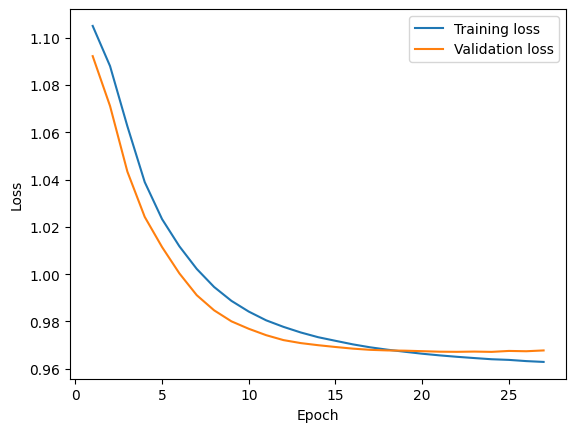

Multi-class classifier results
------------------------------
Train accuracy:      0.87625
Validation accuracy: 0.9
Test accuracy:       0.91


In [ ]:
# Train multi-class model
train_losses_m, val_losses_m = train_model_multi(
    model_multi,
    train_loader_multi,
    val_loader_multi,
    criterion_multi,
    optimizer_multi,
    n_epochs=50,
    patience=3
)

# Plot loss curves
plot_losses(train_losses_m, val_losses_m)

# Final accuracies
tr_loss_m, tr_acc_m = evaluate_multi(model_multi, train_loader_multi, criterion_multi)
val_loss_m, val_acc_m = evaluate_multi(model_multi, val_loader_multi, criterion_multi)
test_loss_m, test_acc_m = evaluate_multi(model_multi, test_loader_multi, criterion_multi)

print("Multi-class classifier results")
print("------------------------------")
print("Train accuracy:     ", tr_acc_m)
print("Validation accuracy:", val_acc_m)
print("Test accuracy:      ", test_acc_m)


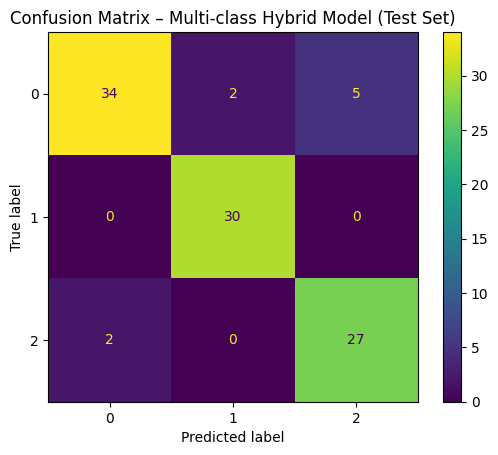

Confusion matrix (multi-class):
[[34  2  5]
 [ 0 30  0]
 [ 2  0 27]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_preds_and_targets_multi(model, data_loader):
    """Collect all predictions and true labels from a dataloader (multi-class)."""
    model.eval()
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for xb, yb in data_loader:
            logits = model(xb)                      # [batch, 3]
            preds = logits.argmax(dim=1).cpu().numpy()
            targets = yb.cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets)

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)
    return y_true, y_pred

# Confusion matrix on the test set
y_true_test_m, y_pred_test_m = get_preds_and_targets_multi(model_multi, test_loader_multi)
cm_m = confusion_matrix(y_true_test_m, y_pred_test_m)

disp_m = ConfusionMatrixDisplay(confusion_matrix=cm_m, display_labels=[0, 1, 2])
disp_m.plot()
plt.title("Confusion Matrix – Multi-class Hybrid Model (Test Set)")
plt.show()

print("Confusion matrix (multi-class):")
print(cm_m)
